# 1. Importing libraries

In [36]:
# Data processing  
# -----------------------------------------------------------------------
import pandas as pd
import numpy as np

# Pandas options  
# -----------------------------------------------------------------------
pd.options.display.max_colwidth = None

# Path configuration for custom module imports
# -----------------------------------------------------------------------
import sys
sys.path.append('../')

# Ignore warnings  
# -----------------------------------------------------------------------
import warnings
warnings.filterwarnings("ignore")

# Clusters and metrics
# -----------------------------------------------------------------------
from yellowbrick.cluster import KElbowVisualizer

# Clustering models
# -----------------------------------------------------------------------
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.cluster import SpectralClustering

# Custom functions and classes
# -----------------------------------------------------------------------
from src.preprocess import preprocess
from src.eda_support import plot_relation_tv
from src.clustering import *


# 2. Data loading

Aquí hay que limpiar el dataset (duplicados y compound)

In [37]:
df = pd.read_csv('../data/output/circuits.csv', index_col=0)

df.head()

,compound,laptime,max_speed,distance,n_corners,avg_corner_speed,avg_speed,throttle_perc,brake_perc,gear_changes
bahrain,SOFT,88.997,311.0,5391.107500,15,174.591753,218.342318,73.134771,18.059299,55.0
imola,SOFT,74.411,290.0,4899.232778,19,214.538960,237.668831,81.048701,13.961039,40.0
portimao,MEDIUM,77.968,314.0,4637.664722,15,188.740533,214.136223,73.058824,17.647059,40.0
catalunya,SOFT,76.741,313.0,4665.113611,16,177.564519,219.068966,75.727273,16.300940,40.0
monaco,SOFT,70.346,279.0,3276.551111,19,146.219753,168.225256,59.266212,26.279863,48.0


In [77]:
df = df[df['compound'] == 'SOFT']

# 3. Preprocessing

* Remove the columns we do not want to consider.

    - In this case, we drop `compound`.

* Select the encoding methods for categorical variables.

    - We do not have categorical variables, so we do not need to perform encoding.

* Select the scaling method.

    - We will initially try using a minmax scaler.

In [78]:
encoding_methods = {}

scaling = 'minmax'

df_encoded, df_scaled = preprocess(df, encoding_methods, scaling, columns_drop=['compound'])

# 4. Clustering

## 4.1 K-means

In [79]:
df_kmeans = df_scaled[['max_speed', 'avg_speed', 'throttle_perc']]

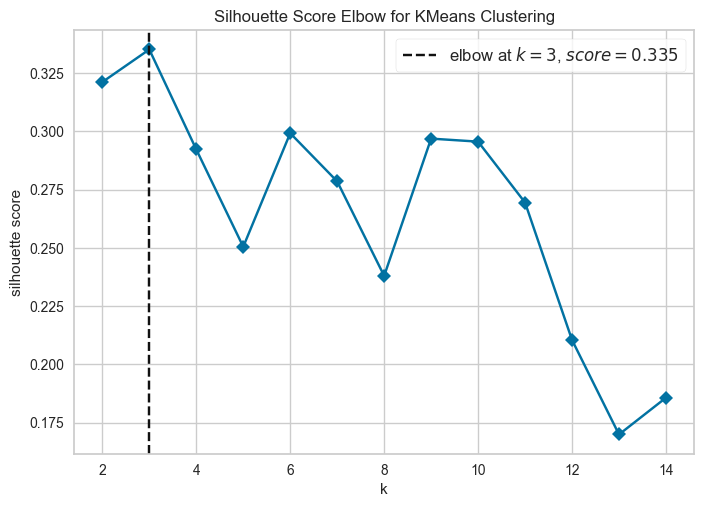

<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [87]:
model = KMeans(random_state=42)

visualizer = KElbowVisualizer(model, k=(2, 15), metric="silhouette", timings=False)
visualizer.fit(df_kmeans)
visualizer.show()

In [89]:
model_kmeans = KMeans(n_clusters=6)

km_fit = model_kmeans.fit(df_kmeans)
labels = km_fit.labels_

In [90]:
clustering_metrics(df_kmeans, labels)

,silhouette_score,davies_bouldin_index,cardinality
0,0.266701,0.533218,5
1,0.266701,0.533218,1
2,0.266701,0.533218,1
3,0.266701,0.533218,9
4,0.266701,0.533218,1
5,0.266701,0.533218,2


In [91]:
df_kmeans_result = df_kmeans.copy()

df_kmeans_result['cluster'] = km_fit.labels_

In [92]:
df_kmeans_result.sort_values(by='cluster')['cluster']

imola            0
losail           0
red_bull_ring    0
silverstone      0
jeddah           0
monaco           1
monza            2
bahrain          3
interlagos       3
americas         3
istanbul         3
zandvoort        3
ricard           3
baku             3
catalunya        3
yas_marina       3
rodriguez        4
hungaroring      5
sochi            5
Name: cluster, dtype: int32

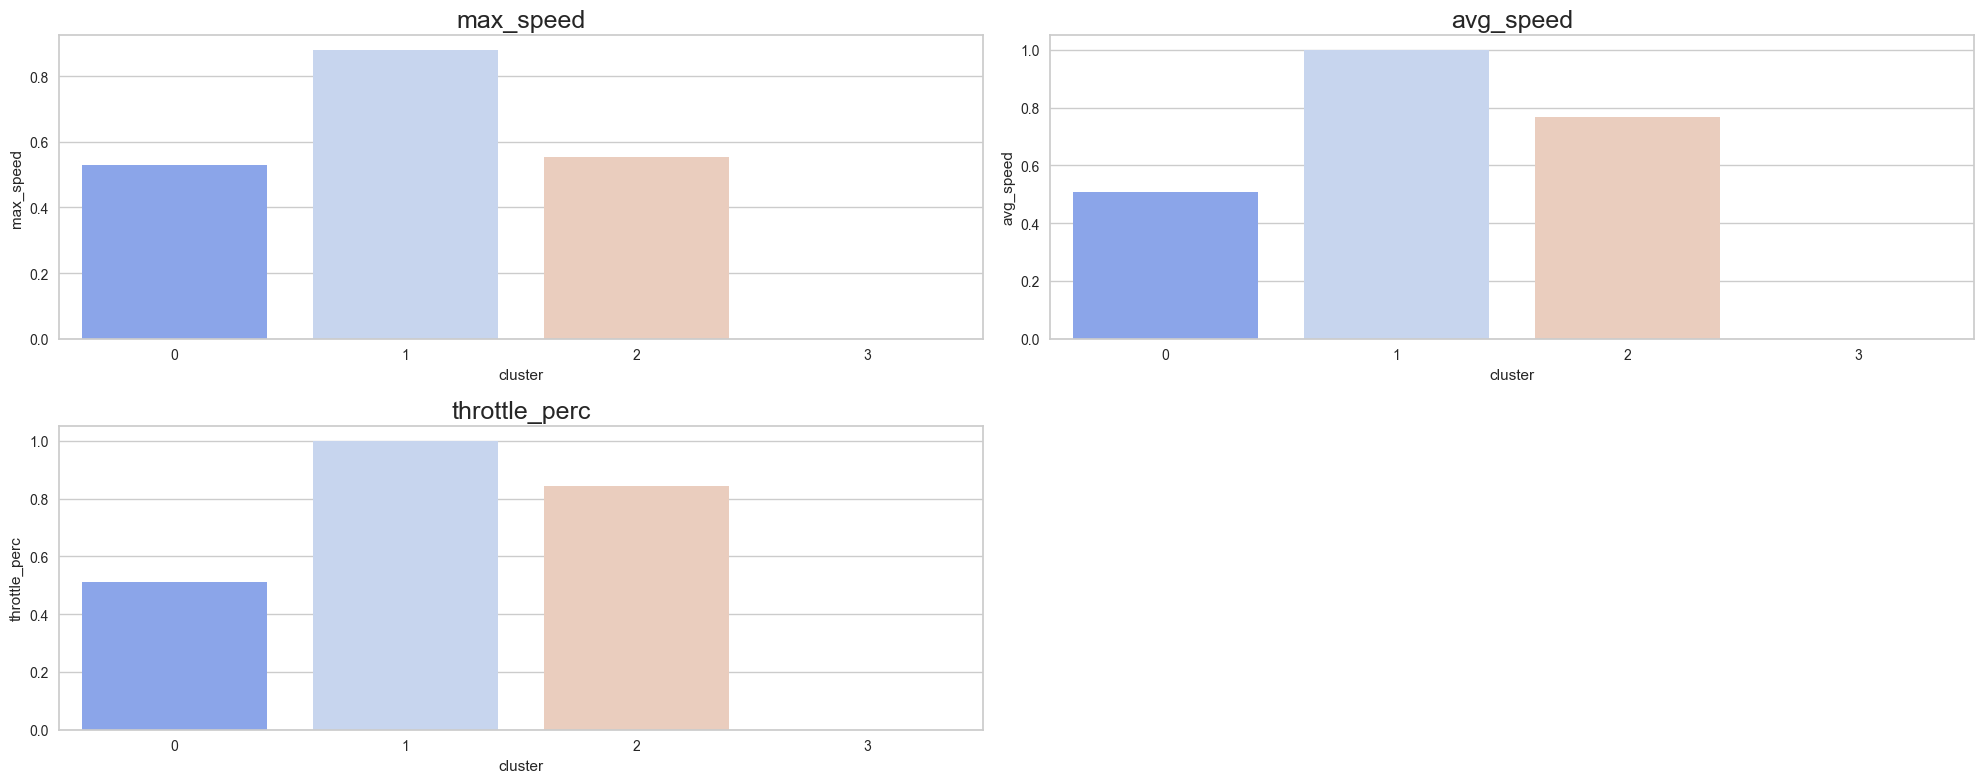

In [73]:
plot_clusters(df_kmeans_result)

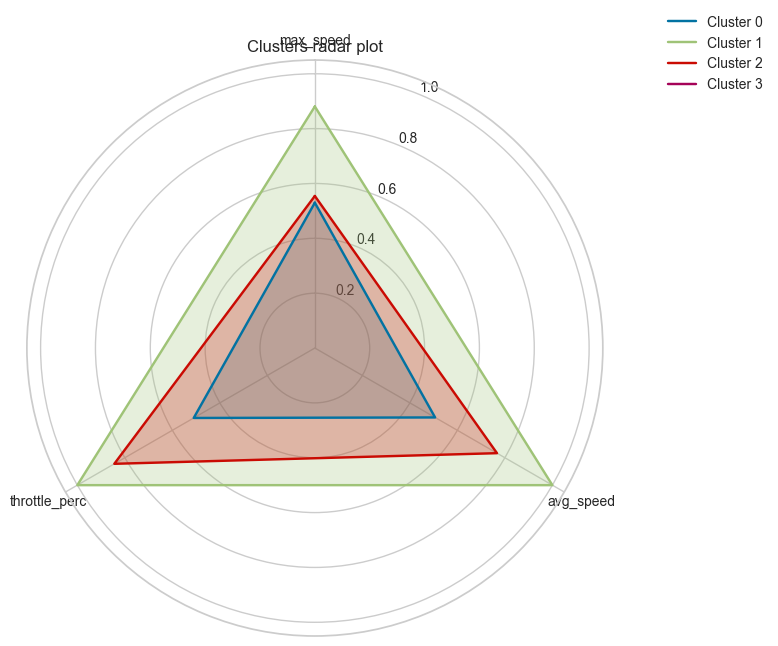

In [74]:
variables = df_kmeans_result.drop(columns='cluster').columns

plot_radar(df_kmeans_result, variables)

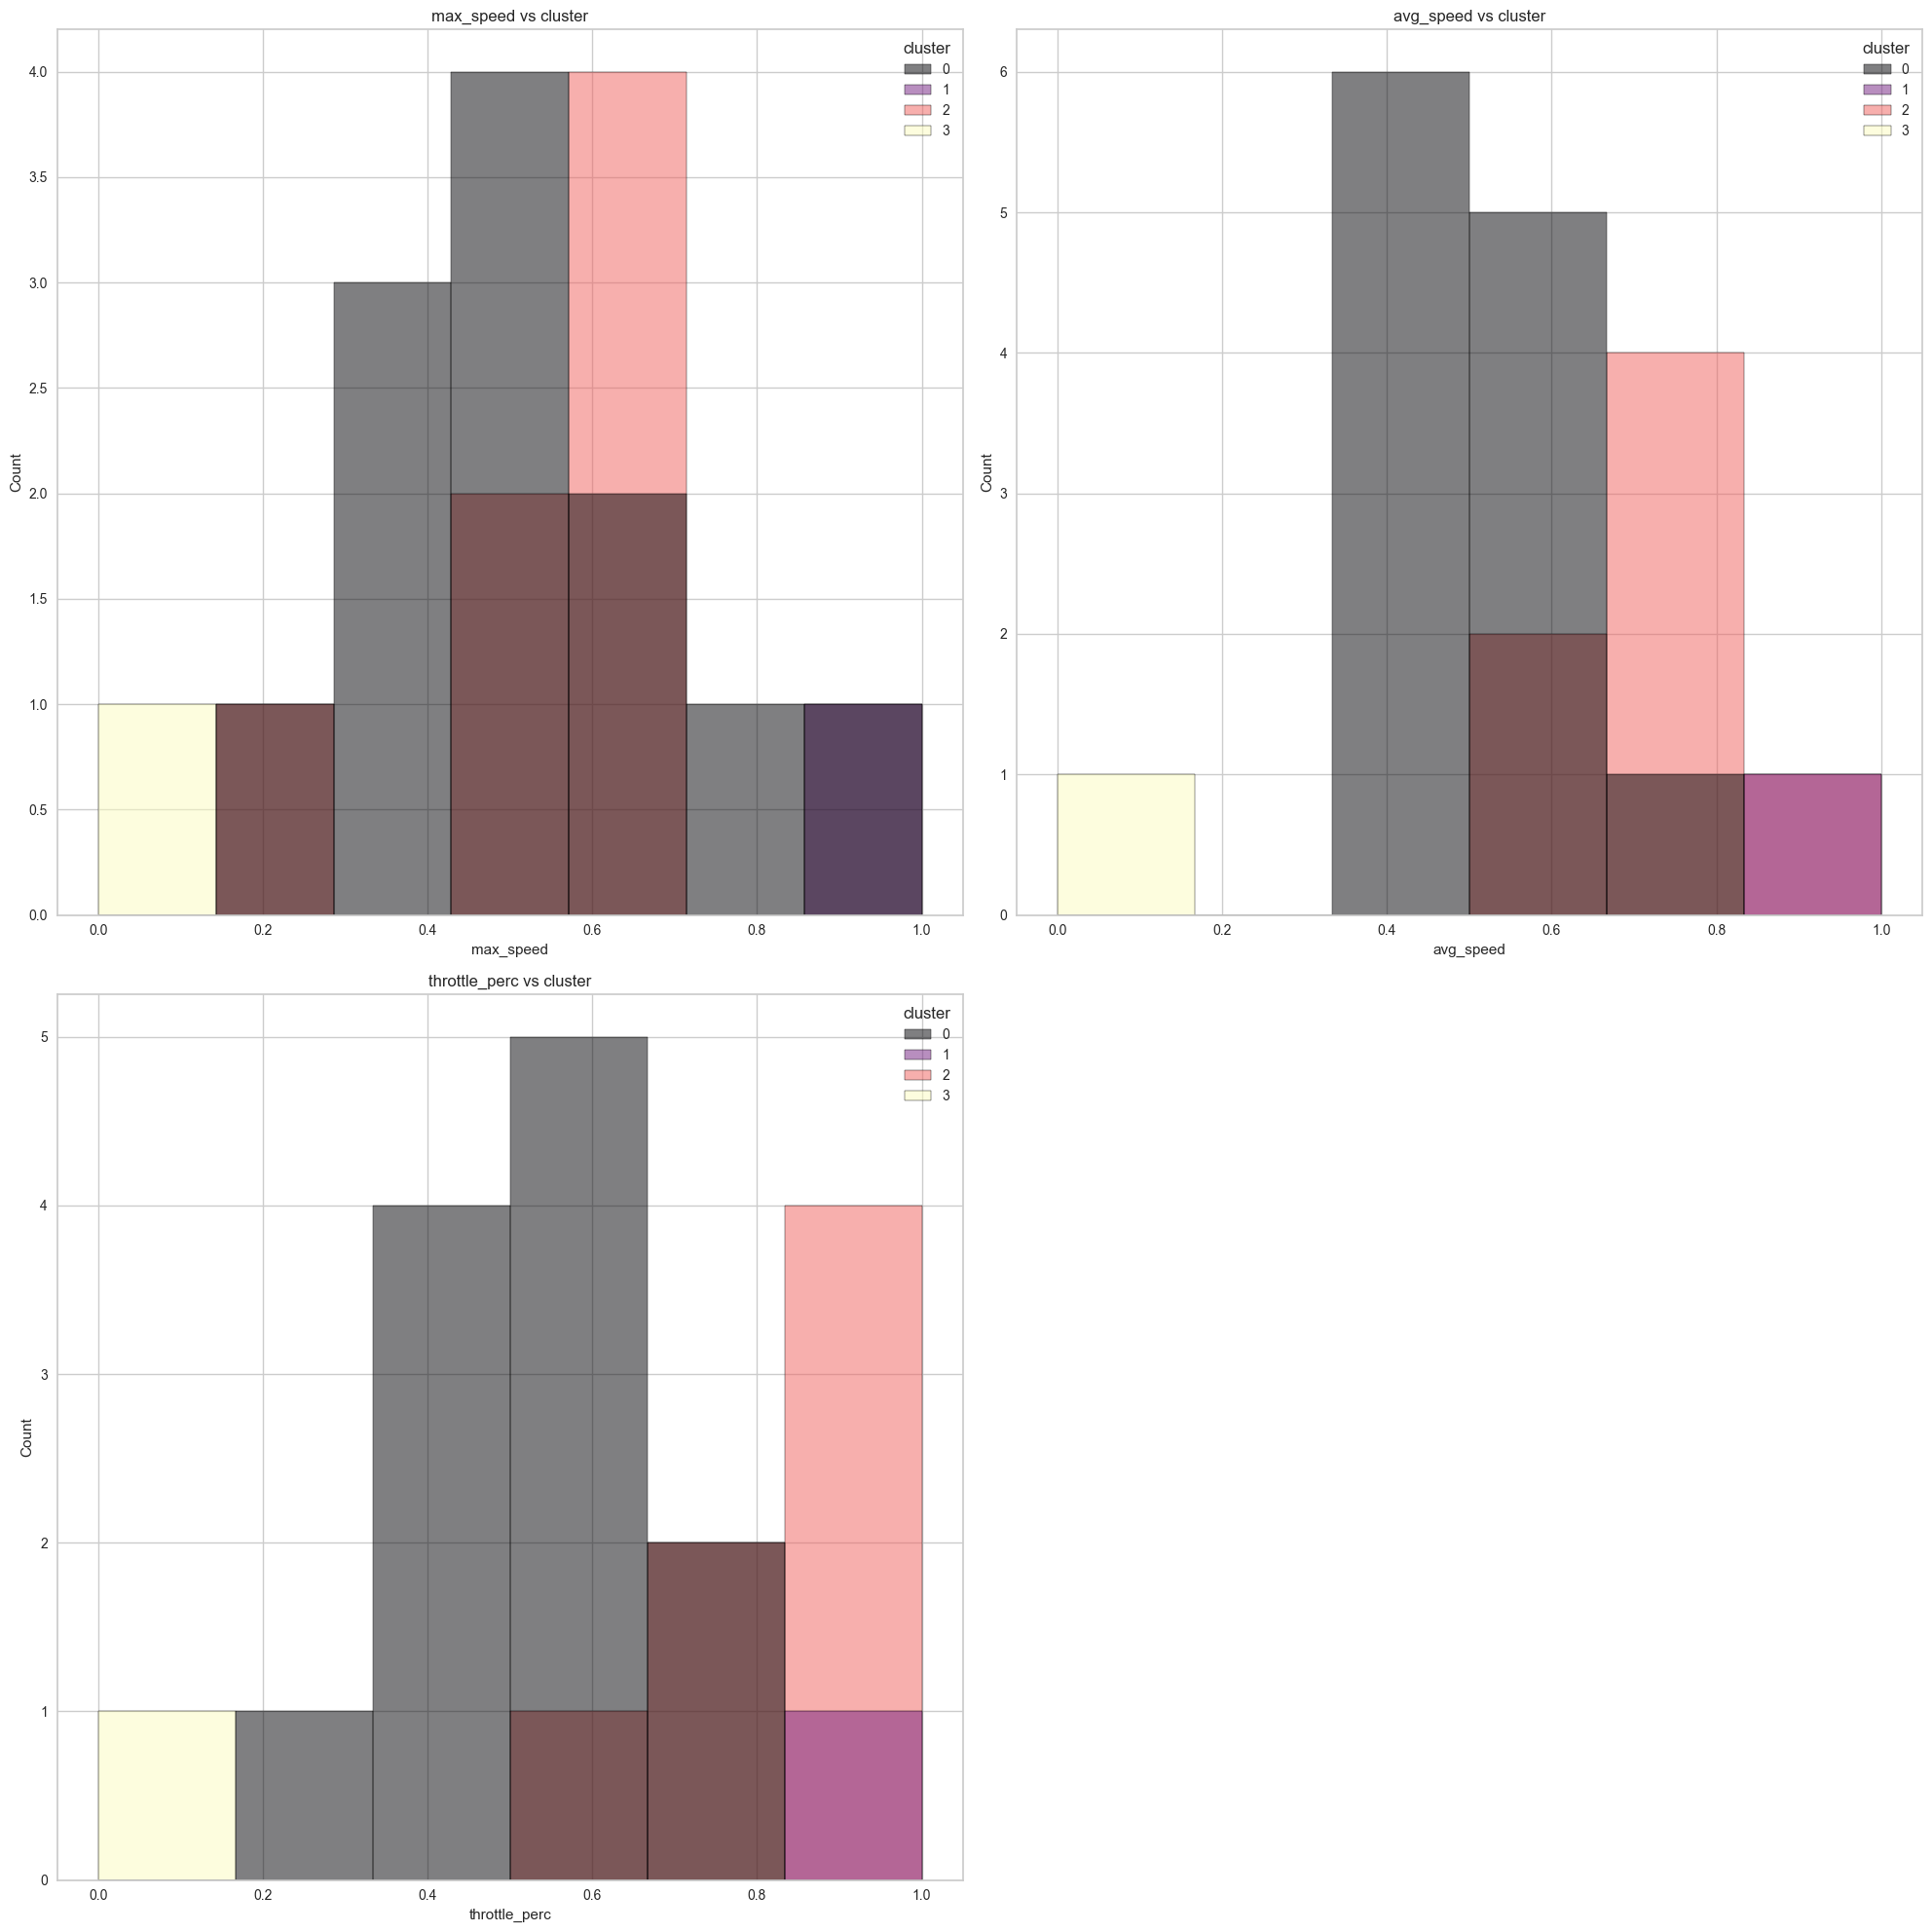

In [75]:
plot_relation_tv(df_kmeans_result, 'cluster', size=(20, 20), n_cols = 2)

## 4.2 Agglomerative clustering

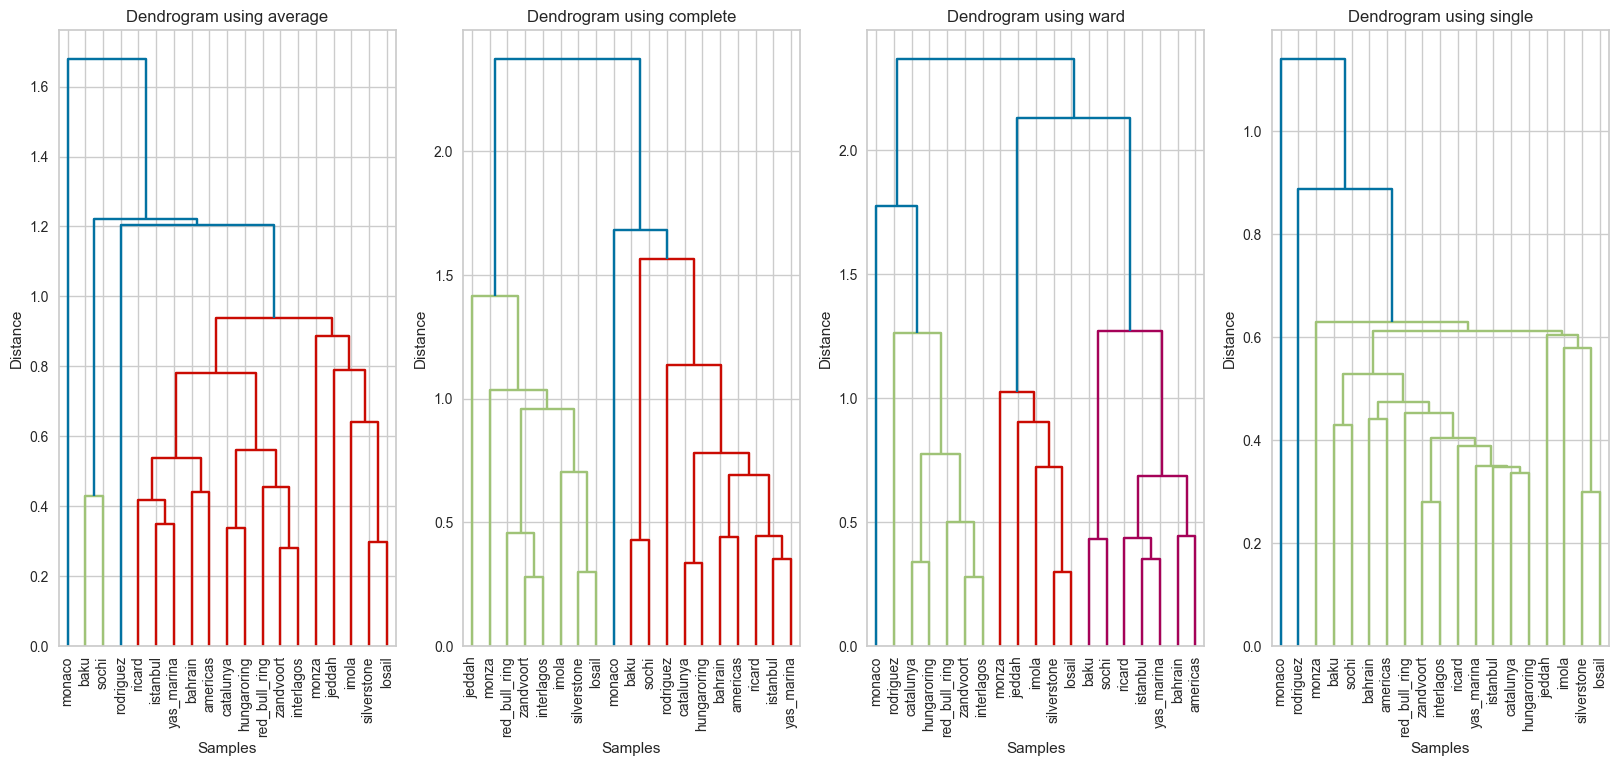

In [93]:
df_copy = df_scaled.copy()

plot_dendrogram(df_copy)